# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess
import pickle
import math

#Set random seed
np.random.seed(1606)

### Functions

In [2]:
# def mem_usage(pandas_obj):
#     if isinstance(pandas_obj,pd.DataFrame):
#         usage_b = pandas_obj.memory_usage(deep=True).sum()
#     else: # we assume if not a df it's a series
#         usage_b = pandas_obj.memory_usage(deep=True)
#     usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
#     return "{:03.2f} MB".format(usage_mb)

### 1. Import Vectors and Pre-Process them

In [3]:
# Import Gofunc vec file
# These are the gofuncs for diseases and chems both from ctd and from vmh, made in opa2vec.
# VMH chems/diseases are to be removed as they are for a validation check
with open('go-gofuncs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [4]:
df.sample(15)

,ID,Vector
1297,MESH:C567764,"[2.59589870e-02, 1.18869647e-01, 4.94366251e-0..."
1791,MESH:C563557,"[-0.00220508, 0.12581137, 0.03101973, -0.11821..."
632,MESH:C564219,"[-2.59858873e-02, 1.27377555e-01, -1.66070759e..."
1166,OMIM:614898,"[2.26386860e-02, 1.09396853e-01, 2.76846923e-0..."
1615,OMIM:615828,"[1.22775771e-02, 1.29769415e-01, 8.57655481e-0..."
1283,MESH:D055371,"[0.02456979, 0.09336999, 0.04372336, -0.103645..."
1668,MESH:D057049,"[0.02601669, 0.13012536, 0.03325291, -0.135834..."
2737,C088658,"[0.04418474, 0.14310175, 0.04817571, -0.159905..."
2075,OMIM:613671,"[0.01726108, 0.10205465, 0.04739797, -0.113752..."
1179,MESH:D004769,"[2.83928532e-02, 1.17765650e-01, 4.06522602e-0..."


In [10]:
# Remove all VMH ids
print(df.shape)
vmh_entities = pd.read_csv('../validation/VMHentities.lst', names=['entity'])
df = df[df.ID.map(lambda x: x not in list(vmh_entities.entity))]
print(df.shape)

(3412, 2)
(3153, 2)


In [11]:
print('ID vec pairs: ', df.shape[0])
print('No. unique entities: ', df.ID.nunique())

ID vec pairs:  3153
No. unique entities:  3153


In [12]:
df.sample(4)

,ID,Vector
2151,OMIM:614418,"[0.01731275, 0.08382709, 0.04467984, -0.096550..."
830,MESH:D016889,"[0.00068161, 0.10528181, 0.00478705, -0.110485..."
2462,OMIM:616900,"[0.00370829, 0.11772701, 0.06661044, -0.115037..."
2398,OMIM:616549,"[0.03555591, 0.12016133, 0.04434789, -0.111885..."


### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [13]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID
0,C112297,MESH:D006948
1,C112297,MESH:D012640
2,C425777,MESH:D006948
3,C013567,MESH:D006333
4,C418863,MESH:D013262


In [14]:
# # Add control rows and correlation col
# chem_dis['Correlation'] = 1

# controls = pd.read_csv('../ctd-to-nt/uncorrelated_chemDis_pairs.csv')
# chem_dis = pd.concat([chem_dis, controls], sort=True)
# chem_dis = chem_dis.fillna(0)

In [15]:
# print('Correlated pairs: ', chem_dis[chem_dis.Correlation == 1].shape[0])
# print('UnCorrelated pairs: ', chem_dis[chem_dis.Correlation == 0].shape[0])
print('No. unique diseases: ', chem_dis.DiseaseID.nunique())
print('No. unique Chems: ', chem_dis.ChemicalID.nunique())

No. unique diseases:  2539
No. unique Chems:  6112


In [16]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [17]:
# print('Correlated pairs: ', chem_dis[chem_dis.Correlation == 1].shape[0])
# print('UnCorrelated pairs: ', chem_dis[chem_dis.Correlation == 0].shape[0])

In [18]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

df1['Correlation'] = 1 # currently only have correlated in there

In [19]:
# # merge all info into one df
# # this df now contains only correlated diseases and vecs
# df_d = df.copy()
# df_d.columns= ['DiseaseID', 'DVec']
# df_c = df.copy()
# df_c.columns= ['ChemicalID', 'CVec']
# df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
# df1 = pd.merge(df1, df_c, on='ChemicalID')

In [20]:
# del df1['index']
df1.sample(6)

,ChemicalID,DiseaseID,DVec,CVec,Correlation
3184,D037742,MESH:D002471,"[-0.0351216, 0.12595233, -0.03002397, -0.10022...","[0.01232813, 0.12974437, -0.00763494, -0.13151...",1
6590,D005472,MESH:D002972,"[-1.06637282e-02, 1.32474691e-01, -1.14339013e...","[-2.96734683e-02, -7.76007175e-02, -4.85067695...",1
365,D001564,MESH:D009362,"[-0.06323989, -0.00838911, -0.21696223, -0.110...","[-6.56977762e-04, 1.15829483e-02, -3.29673588e...",1
4306,D004008,MESH:D007410,"[0.01581571, 0.13125835, 0.05351888, -0.116338...","[-0.02403709, 0.08844553, -0.10826206, -0.1294...",1
2533,D003042,MESH:D056486,"[-5.73407635e-02, 5.87317832e-02, -2.38079086e...","[8.72457493e-03, 1.21514283e-01, -1.06348200e-...",1
3053,D005632,MESH:D056486,"[-5.73407635e-02, 5.87317832e-02, -2.38079086e...","[-0.06154032, 0.02354902, -0.5231033, -0.13852...",1


### Add control (uncorrelated) rows

In [21]:
# len(id_list)

In [22]:
# chem_dis.shape

In [24]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [25]:
# # Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
# dis = df1.ChemicalID.unique()
# chems = df1.DiseaseID.unique()

In [26]:
# Add unrelated pairs to df1
no_rows = (df1.shape[0]-1)  # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print('shape: ', no_rows)

# Make list to check chem-dis pos assocs against
chem_dis_pos_assocs = list(chem_dis['ChemicalID'] + chem_dis['DiseaseID'])

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    if (chem + dis not in chem_dis_pos_assocs):
        df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)


shape:  8919
(17791, 5)
(17739, 5)


In [27]:
# # Add unrelated pairs to df1

# no_rows = (df1.shape[0]-1) * 10  # This is a parameter to be tuned --> how many uncorrelated pairs do we want
# print('shape: ', no_rows)

# # Make list to check chem-dis pos assocs against
# chem_dis_pos_assocs = list(chem_dis['ChemicalID'] + chem_dis['DiseaseID'])

# # Randomly select chems and diseases (as many as there are related pairs)
# no_chems = len(chems) -1
# no_dis = len(dis) -1
# rand_chems = np.random.choice(no_chems, no_rows, replace=True)
# rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# # Add the new pairs as rows
# for x in range(0, no_rows):
#     int1 = rand_chems[x]
#     int2 = rand_dis[x]
#     chem, chemvec = df1.loc[int1, 'ChemicalID'], df1.loc[int1, 'CVec']
#     dis, disvec = df1.loc[int2, 'DiseaseID'], df1.loc[int2, 'DVec']
#     if (chem + dis not in chem_dis_pos_assocs):
#         df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

# print(df1.shape)
# # Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
# df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
# print(df1.shape)

In [28]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

### Add Phenotype Vecs
Got a list of Chem-Phenotypes from Sara Alth, where did these come from originally?
They have CID identifiers (Pubchem). Need to convert CTD ID to CID ID
Use API like so 
http://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/Comparative%20Toxicogenomics%20Database/C533207/cids/TXT/

In [29]:
# First Get FULL list of diseases from CTD
diseases = pd.read_csv('../ctd-to-nt/all-diseases-w-genes-ctd.txt', names=['MESH'])
diseases.head()

,MESH
0,MESH:D003920
1,MESH:D003924
2,MESH:D008113
3,MESH:D009369
4,MESH:D009765


In [30]:
# Then use premade map to get DOIDs for MESHs
mapper = pd.read_csv('chem_dis_to_CID_DOID.csv')
print(mapper.DOID.nunique()) # 1671
mesh_to_doid = dict(zip(mapper.ID, mapper.DOID))
diseases['DOID'] = diseases.MESH.map(lambda x: mesh_to_doid.get(x))

1671


In [31]:
df1['DOID'] = df1.DiseaseID.map(lambda x: mesh_to_doid.get(x))

In [32]:
# # Then get phens for all DOIDs
# # Read in the association file from Sara
# dis_phens = pd.read_csv('../opa/Disease-PhenotypeAssocation.txt', sep=' ', names=['DOID', 'Phenotype'])

# # Let's create one associations file for each ontology (I believe we need to run HP and MP separately)
# dis_phens.columns = ['ID', 'Phen']

# # Split into MP/HP
# total_hp = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
# total_mp = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))

# total_hp = dis_phens[total_hp]
# total_mp = dis_phens[total_mp]

In [33]:
# # Export the association files and print some stats (more stats later)
# np.savetxt(r'associations_hp.txt', total_hp.values, fmt='%s')
# np.savetxt(r'associations_mp.txt', total_mp.values, fmt='%s')

# print('Num HP associations: ', total_hp.shape[0])
# print('Num MP associations: ', total_mp.shape[0])
# print('Num ents with MP phen assocs: ', len(total_mp.ID.unique()))
# print('Num ents with HP phen assocs: ', len(total_hp.ID.unique()))

# # Create entities lists to inform opa2vec which entities we want vectors for
# entities = total_mp.ID.unique().tolist()
# np.savetxt(r'entities_mp.lst', entities, fmt='%s')

# entities = total_hp.ID.unique().tolist()
# np.savetxt(r'entities_hp.lst', entities, fmt='%s')

In [34]:
# # HP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/hp.owl -associations ../msc-thesis/opa/associations_hp.txt -entities ../msc-thesis/opa/entities_hp.lst -outfile ../msc-thesis/opa/hpvecs.lst)', shell=True)

In [35]:
# # # MP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/mp.owl -associations ../msc-thesis/opa/associations_mp.txt -entities ../msc-thesis/opa/entities_mp.lst -outfile ../msc-thesis/opa/mpvecs.lst)', shell=True)

In [36]:
# # Now import and integrate the vecs (all phen stuff above here should be in its own notebook )
# # Import vec file
# with open('hpvecs.lst', 'r') as file:
#     text = file.read()
    
# # Strip and split vector data into list of lists [chem, vec]
# text = text.replace('\n', '')
# text = text.split(']')
# text = [item.strip().split(' [') for item in text]

# # Turn it into a data frame
# hp_vecs = pd.DataFrame(text)
# hp_vecs.columns = ['ID', 'Vector']

# # Clean
# hp_vecs = hp_vecs.dropna()
# hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# # Turn vector column into a list
# hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.split(','))

In [37]:
# # Now import and integrate the mp vecs
# # Import vec file
# with open('mpvecs.lst', 'r') as file:
#     text = file.read()

# # Strip and split vector data into list of lists [chem, vec]
# text = text.replace('\n', '')
# text = text.split(']')
# text = [item.strip().split(' [') for item in text]

# # Turn it into a data frame
# mp_vecs = pd.DataFrame(text)
# mp_vecs.columns = ['ID', 'Vector']

# # Clean
# mp_vecs = mp_vecs.dropna()
# mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# # Turn vector column into a list
# mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.split(','))

In [38]:
# # Make Maps:
# mp_ent_to_vec = dict(zip(mp_vecs.ID, mp_vecs.Vector))
# hp_ent_to_vec = dict(zip(hp_vecs.ID, hp_vecs.Vector))

In [39]:
# # export dis-mpVec and dis-hpVec maps
# with open('dis_mpVec_map'+ '.pkl', 'wb') as f:
#         pickle.dump(mp_ent_to_vec, f, pickle.HIGHEST_PROTOCOL)
        
# with open('dis_hpVec_map'+ '.pkl', 'wb') as f:
#         pickle.dump(hp_ent_to_vec, f, pickle.HIGHEST_PROTOCOL)

In [40]:
## The commented section above makes phen vecs for all ctd diseases that have doids. Import here 
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

dis_mpVec = load_obj('../opa/dis_mpVec_map')

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

dis_hpVec = load_obj('../opa/dis_hpVec_map')

In [41]:
# Standardise the DOIDs
def doid_standardiser (doid):
    doid = doid.replace(':', '_')
    return doid

df1['DOID'] = df1.DOID.astype(str).map(lambda x: np.nan if isinstance(x, float) else doid_standardiser(x))

In [42]:
# Map entities to vecs (one set of vecs for mp and another for hp)
df1['disPhenVecMP'] = df1.DOID.map(lambda x: dis_mpVec.get(x))
df1['disPhenVecHP'] = df1.DOID.map(lambda x: dis_hpVec.get(x))

df1['chemPhenVecHP'] = None
df1['chemPhenVecMP'] = None

In [43]:
## TODO note that I have removed rows without gofuncVecs, maybe now they should be kept
# Print Stats
print('Note these numbers include both correlated and uncorrelated pairs')
print('Number of rows with gofuncs: ', df1.shape[0]) ##NB change this if keeping rows w/o gofunc vecs
print('Number of rows with dis mp vec: ', df1[df1.disPhenVecMP.map(lambda x: x is not None)].shape[0])
print('Number of rows with dis hp vec: ', df1[df1.disPhenVecHP.map(lambda x: x is not None)].shape[0])
# print('Number of rows with chem mp vec: ', df1[df1.chemPhenVecMP.map(lambda x: x is not None)].shape[0])
# print('Number of rows with chem hp vec: ', df1[df1.chemPhenVecHP.map(lambda x: x is not None)].shape[0])
no_dis_phen_vecs = df1.disPhenVecHP.map(lambda x: x is None) & df1.disPhenVecMP.map(lambda x: x is None)
# no_chem_phen_vecs = df1.chemPhenVecHP.map(lambda x: x is None) & df1.chemPhenVecMP.map(lambda x: x is None)
# no_phen_vecs = no_dis_phen_vecs & no_chem_phen_vecs
# print('Number of rows with no phen vecs: ', df1[no_phen_vecs].shape[0])
all_dis_phen_vecs = df1.disPhenVecHP.map(lambda x: x is not None) & df1.disPhenVecMP.map(lambda x: x is not None)
# all_chem_phen_vecs = df1.chemPhenVecHP.map(lambda x: x is not None) & df1.chemPhenVecMP.map(lambda x: x is not None)
# all_vecs = all_dis_phen_vecs & all_chem_phen_vecs
# all_vecs_pos_corr = all_vecs & df1.Correlation.map(lambda x: x == 1)
# all_vecs_neg_corr = all_vecs & df1.Correlation.map(lambda x: x == 0)
# no_phen_vecs_corr = no_phen_vecs & df1.Correlation.map(lambda x: x == 1)
# no_phen_vecs_uncorr = no_phen_vecs & df1.Correlation.map(lambda x: x == 0)



# print('Number of rows with everything', df1[all_vecs].shape[0])

# print('Number of correlated pairs with phenvecs', df1[no_phen_vecs_corr].shape[0])
# print('Number of uncorrelated pairs with phenvecs', df1[no_phen_vecs_uncorr].shape[0])


# print('Number of correlated pairs with everything', df1[all_vecs_pos_corr].shape[0])
# print('Number of uncorrelated pairs with everything', df1[all_vecs_neg_corr].shape[0])

print('total pos corr', df1[df1.Correlation.map(lambda x: x == 1)].shape[0])
print('total neg corr', df1[df1.Correlation.map(lambda x: x == 0)].shape[0])

Note these numbers include both correlated and uncorrelated pairs
Number of rows with gofuncs:  17739
Number of rows with dis mp vec:  6593
Number of rows with dis hp vec:  6593
total pos corr 8920
total neg corr 8819


In [44]:
# Add empty vecs for rows that don't have phen vecs
empty_vec = [0] * 200

for col in ['disPhenVecMP', 'disPhenVecHP', 'chemPhenVecHP', 'chemPhenVecMP']:
    df1[col] = df1[col].map(lambda x: empty_vec if x is None else x)

In [45]:
# Change the Phen vec elements from string to floats
df1['disPhenVecHP'] = df1.disPhenVecHP.map(lambda x: [float(i) for i in x])
df1['disPhenVecMP'] = df1.disPhenVecMP.map(lambda x: [float(i) for i in x])
df1['chemPhenVecHP'] = df1.chemPhenVecHP.map(lambda x: [float(i) for i in x])
df1['chemPhenVecMP'] = df1.chemPhenVecMP.map(lambda x: [float(i) for i in x])

### Add CHEBI Vecs

In [46]:
# get ALL ctd chems that have gene associations
chems = pd.read_csv('allchemsthathavegenesID.txt', names=['ChemicalID'])
chems.shape # 12855

(12885, 1)

In [47]:
# Map them to CIDs
# Load the map from pickle object
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

ctd_cid_map = load_obj('ctd_cid_map')

chems['CID'] = chems.ChemicalID.map(lambda x: ctd_cid_map.get(x))

In [48]:
chems.CID.unique()[5:15]

array([b'5494506', None, b'11267663', b'113918', b'10079106', b'10424358',
       b'24762158', b'122347', b'97226', b'6420504'], dtype=object)

In [49]:
# Convert CIDS from bytes to strings and export in order to make a map from CID to CHEBI ID
chems['CID'] = chems.CID.str.decode("utf-8")
np.savetxt(r'allCIDs.txt', chems.CID.unique(), fmt='%s')

## NOTE the next step is MANUAL you need to upload this allCIDs.txt to http://cts.fiehnlab.ucdavis.edu/batch 
# and download it as ctd_chebi.csv to the current folder
# !!! it no longer seems possible to convert from CID by the website. Think I'll need to write a script
# and use the API. Currently running the website to convert from chemical name. 
# Right seems like API isn't working for my purposes either right now. Will cobble CHEBIs together from my
# earlier download of this file, which wasn't comprehensive, plus what I can get from chem name (~20%)

In [50]:
# import the chebi IDs I got from all chem names (about 1 in in 3)
chebi_from_names = pd.read_csv('all_chem_names_chebi.csv')

# chop any empty values
chebi_from_names['ChEBI'] = chebi_from_names.ChEBI.map(lambda x: np.nan if x == 'No result' else x)
chebi_from_names = chebi_from_names.dropna()

# make map
chem2chebi = dict(zip(chebi_from_names['Chemical Name'], chebi_from_names.ChEBI))

In [51]:
chebi_from_names.head()

,Chemical Name,ChEBI
1,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",CHEBI:35046
2,"10,11-dihydro-10,11-dihydroxy-5H-dibenzazepine...",CHEBI:4592
3,"10,11-dihydro-10-hydroxycarbamazepine",CHEBI:701
14,10-formyltetrahydropteroylglutamic acid,CHEBI:15637
15,10-hydroxycamptothecin,CHEBI:81395


In [52]:
chebi_from_names.shape

(4489, 2)

In [53]:
# Now import a second chebi map, one made earlier from CIDs tho only for chems with go vecs
# Import CSV mapping CID to CHEBI
ctdChebdf = pd.read_csv('ctd_chebiBACKUP.csv')

# Turn it into a dict
cid2chebi = dict(zip(ctdChebdf['PubChem CID'], ctdChebdf['ChEBI']))

# Map the cids to chebis
chems['CHEBI1'] = chems.CID.map(lambda x: cid2chebi.get(x))
chems['CHEBI1'] = chems.CHEBI1.map(lambda x: None if x == 'No result' else x)

In [54]:
chems.CHEBI1.nunique() # 314

314

In [55]:
# Must map chem names into our chems df before applying chemname2chebi
chemnames = pd.read_csv('../ctd-to-nt/chemname_chemid.csv')

In [56]:
chemnames.head()

,ChemicalID,# ChemicalName
0,C046983,06-Paris-LA-66 protocol
1,C112297,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone"
2,C112297,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone"
3,C039775,"10,11-dihydro-10-hydroxycarbamazepine"
4,C425777,"10,11-dihydroxy-N-n-propylnorapomorphine"


In [57]:
# Make a map of it
id2name = dict(zip(chemnames.ChemicalID, chemnames['# ChemicalName']))

In [58]:
chems['ChemicalName'] = chems.ChemicalID.map(lambda x: id2name.get(x))

In [59]:
chems.head()

,ChemicalID,CID,CHEBI1,ChemicalName
0,C534883,2836600,None,None
1,C112297,656732,None,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone"
2,C004822,83852,None,None
3,C039775,114709,None,"10,11-dihydro-10-hydroxycarbamazepine"
4,C515697,70029,None,None


In [60]:
# Map the names to chebis
chems['CHEBI2'] = chems.ChemicalName.map(lambda x: chem2chebi.get(x))
chems['CHEBI2'] = chems.CHEBI2.map(lambda x: None if x == 'No result' else x)

In [61]:
chems.CHEBI2.nunique() # 2791

2791

In [62]:
# Merge the CHEBIs
chems.CHEBI1.fillna(chems.CHEBI2, inplace=True)
chems.CHEBI1.nunique()

2821

In [63]:
# Cleaning
del chems['CHEBI2']
chems = chems.rename(columns = {'CHEBI1':'CHEBI'})

In [64]:
# Make assoc file and entity file for opa
# add uri col
chems['CHEBI_uri'] = chems.dropna(subset=['CHEBI']).CHEBI.map(lambda x: '<http://purl.obolibrary.org/obo/' + x.replace(':', '_') + '>')

# export association file from df
np.savetxt(r'CHEBIassociations.txt', chems[['ChemicalID', 'CHEBI_uri']].dropna().drop_duplicates().values, fmt='%s')

# Now an entities file
chems_for_cheb = chems[['ChemicalID', 'CHEBI_uri']].dropna().drop_duplicates().ChemicalID.tolist()
np.savetxt(r'CHEBIentities.txt', chems_for_cheb, fmt='%s')

In [65]:
# # Run opa
# # Commenting this out now that I already have the vectors, you'll need it if you don't have them
# # Now run opa2vec on it 
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/chebi.owl -associations ../msc-thesis/opa/CHEBIassociations.txt -entities ../msc-thesis/opa/CHEBIentities.txt -outfile ../msc-thesis/opa/chebi-vecs.lst)', shell=True)

In [66]:
# All below is original iteration that only dealt with chems that have govecs
# First add CHEBI IDs for each chem

In [67]:
# chem_names = df1.ChemicalID.unique().tolist()
# np.savetxt(r'chem_names', total_hp.values, fmt='%s')

In [68]:
# # To add chebi first need CID for ALL Chems so I made this comprehensive map:
# # Load the map from pickle object
# def load_obj(name):
#     with open(name + '.pkl', 'rb') as f:
#         return pickle.load(f)

# ctd_cid_map = load_obj('ctd_cid_map')

In [69]:
# df1['CID'] = df1.ChemicalID.map(lambda x: ctd_cid_map.get(x))

In [70]:
# df1.sample(3)

In [71]:
# # Convert CIDS from bytes to strings and export in order to make a map from CID to CHEBI ID
# df1['CID'] = df1.CID.str.decode("utf-8")
# np.savetxt(r'allCIDs.txt', df1.CID.unique(), fmt='%s')

# ## NOTE the next step is MANUAL you need to upload this allCIDs.txt to http://cts.fiehnlab.ucdavis.edu/batch 
# # and download it as ctd_chebi.csv to the current folder

In [72]:
# # How many chemicals don't have CIDs? Hence don't get chebi vecs
# print(df1.shape[0])
# print(df1[df1.CID.map(lambda x: x is not None)].shape[0])

In [73]:
# # Import CSV mapping CID to CHEBI
# ctdChebdf = pd.read_csv('ctd_chebiBACKUP.csv')

In [74]:
# ctdChebdf.head()

In [75]:
# # Import CSV mapping CID to CHEBI
# ctdChebdf = pd.read_csv('ctd_chebiBACKUP.csv')

# # Turn it into a dict
# ctd_chebi = dict(zip(ctdChebdf['PubChem CID'], ctdChebdf['ChEBI']))

# # Map the cids to chebis
# df1['CHEBI'] = df1.CID.map(lambda x: ctd_chebi.get(x))
# df1['CHEBI'] = df1.CHEBI.map(lambda x: None if x == 'No result' else x)

In [76]:
# # Now make CHEBI vecs using the CHEBI IDs
# # First an association file - just linking each chebi to its own chebi entity

# # add uri col
# df1['CHEBI_uri'] = df1.dropna(subset=['CHEBI']).CHEBI.map(lambda x: '<http://purl.obolibrary.org/obo/' + x.replace(':', '_') + '>')

# # export association file from df
# np.savetxt(r'CHEBIassociations.txt', df1[['ChemicalID', 'CHEBI_uri']].dropna().drop_duplicates().values, fmt='%s')

# # Now an entities file
# chems_for_cheb = df1[['ChemicalID', 'CHEBI_uri']].dropna().drop_duplicates().ChemicalID.tolist()
# np.savetxt(r'CHEBIentities.txt', chems_for_cheb, fmt='%s')

In [77]:
# Commenting this out now that I already have the vectors, you'll need it if you don't have them
# # Now run opa2vec on it 
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/chebi.owl -associations ../msc-thesis/opa/CHEBIassociations.txt -entities ../msc-thesis/opa/CHEBIentities.txt -outfile ../msc-thesis/opa/chebi-vecs.lst)', shell=True)

In [78]:
# Import CHEBI vec file
with open('chebi-vecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (ChemID to CHEBIvec)
chem_to_chebi_vec = dict(zip(df.ID, df.Vector))

In [79]:
# Export the chem2chebi map for use in validation databases
# export dis-mpVec and dis-hpVec maps
with open('chem2chebi'+ '.pkl', 'wb') as f:
        pickle.dump(chem_to_chebi_vec, f, pickle.HIGHEST_PROTOCOL)


In [80]:
df1['CHEBIvec'] = df1.ChemicalID.map(lambda x: chem_to_chebi_vec.get(x))

In [81]:
# How many rows have CHEBI Vecs?
print('Total Rows', df1.shape[0])
print('Total Correlated Rows', df1[df1.Correlation == 1].shape[0])
print('Total CHEBI vec rows', df1.dropna(subset=['CHEBIvec']).shape[0])
print('Total CHEBI vec correlated rows', df1[df1.Correlation == 1].dropna(subset=['CHEBIvec']).shape[0])
print('Total Chems', len(df1.ChemicalID.unique()))
print('Total Chems with CHEBI Vec', len(df1.dropna(subset=['CHEBIvec']).ChemicalID.unique()))
# Total Rows 17675
# Total Correlated Rows 8869
# Total CHEBI vec rows 5323
# Total CHEBI vec correlated rows 3361
# Total Chems 586
# Total Chems with CHEBI Vec 131

Total Rows 17739
Total Correlated Rows 8920
Total CHEBI vec rows 10825
Total CHEBI vec correlated rows 6150
Total Chems 586
Total Chems with CHEBI Vec 312


In [82]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBIvec
9643,D017313,OMIM:617065,"[0.01894779, 0.10575829, 0.03266486, -0.120980...","[0.0226929933, 0.14501299, 0.0597290248, -0.15...",0,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",None
14736,C074283,MESH:C535702,"[0.01089955, 0.14402176, 0.03286817, -0.150193...","[-0.0133901061, 0.116737746, 0.0253758859, -0....",0,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01771633, 0.06411772, 0.03854137, -0.056743..."
7342,D012969,MESH:D008569,"[-0.00122191, 0.12140676, -0.06278317, -0.1614...","[0.000285959075, 0.148733377, 0.0078057549, -0...",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01631292, 0.04949443, 0.01545214, -0.064467..."


In [83]:
# Add empty vecs for rows that don't have Chebi vecs
empty_vec = [0] * 200
df1['CHEBIvec'] = df1['CHEBIvec'].map(lambda x: empty_vec if x is None else x)

# Change the Chebi vec elements from string to floats
df1['CHEBIvec'] = df1.CHEBIvec.map(lambda x: [float(i) for i in x])

### Add DO Vecs

In [84]:
# Import Gofunc vec file
with open('do-vecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [disease, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (DisID to DOvec)
dis_to_DOvec = dict(zip(df.ID, df.Vector))

In [85]:
df1['DOvec'] = df1.DiseaseID.map(lambda x: dis_to_DOvec.get(x))

In [86]:
# print(df1[df1.DOvec])

In [87]:
# Change the DO vec elements from string to floats
df1['DOvec'] = df1.DOvec.map(lambda x: [float(i) for i in x])

### ADD HINO vecs
This file is getting a bit long 

In [88]:
# Import HINO vec file
with open('hinoVecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (DisID to DOvec)
entity_to_HINOvec = dict(zip(df.ID, df.Vector))

In [89]:
df1['dis_HINOvec'] = df1.DiseaseID.map(lambda x: entity_to_HINOvec.get(x))
df1['chem_HINOvec'] = df1.ChemicalID.map(lambda x: entity_to_HINOvec.get(x))

In [90]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec
97,D020106,MESH:D056486,"[-0.0573407635, 0.0587317832, -0.238079086, -0...","[0.0128343292, 0.124974281, 0.0104902657, -0.1...",1,DOID_2044,"[0.03577727, 0.14357965, 0.07754436, -0.120751...","[0.0365341567, 0.127054989, 0.0648834854, -0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02180431, 0.06118587, 0.03683005, -0.068677...","[0.018791426, 0.0550314896, 0.0336739607, -0.0...","[2.86019761e-02, 9.30668786e-02, 5.02847470e-0...",None
15064,C099813,MESH:C562729,"[0.01318017, 0.1251859, -0.01394415, -0.118188...","[0.02968111, 0.10238931, 0.04476682, -0.105589...",0,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01368068, 0.05909523, 0.03674051, -0.064458...","[0.01388473, 0.05762913, 0.03025182, -0.068478...",None
17177,D005372,MESH:D001943,"[-0.09880375, -0.07782761, -0.21784736, -0.094...","[-0.00116740179, 0.0805704072, -0.0103234174, ...",0,DOID_3459,"[0.01410411, 0.14874491, 0.08110969, -0.131416...","[0.0351502, 0.12961534, 0.0613326, -0.11818561...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0122307669, 0.0684281364, 0.0275013242, -0....","[0.0268149339, 0.0863542259, 0.0386081785, -0....","[2.97578666e-02, 1.17261335e-01, 4.91196848e-0...","[1.66756362e-02, 4.36262824e-02, 2.67493427e-0..."


In [91]:
print('HINO dis vecs: ', df1[df1.dis_HINOvec.map(lambda x: x is not None)].shape[0])
print('HINO chem vecs: ', df1[df1.chem_HINOvec.map(lambda x: x is not None)].shape[0])
at_least_one = df1.chem_HINOvec.map(lambda x: x is not None) | df1.dis_HINOvec.map(lambda x: x is not None)
print('At least one hino vec: ', df1[at_least_one].shape[0])

HINO dis vecs:  11456
HINO chem vecs:  11516
At least one hino vec:  15476


In [92]:
# Add empty vecs in place of None
empty_vec = [0] * 200

for col in ['dis_HINOvec', 'chem_HINOvec']:
    df1[col] = df1[col].map(lambda x: empty_vec if x is None else x)

In [93]:
# Change the HINO vec elements from string to floats
df1['dis_HINOvec'] = df1.dis_HINOvec.map(lambda x: [float(i) for i in x])
df1['chem_HINOvec'] = df1.chem_HINOvec.map(lambda x: [float(i) for i in x])

In [94]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec
0,C028474,MESH:D006528,"[-0.0826218948, 0.0322816819, -0.121060327, -0...","[0.0135123692, 0.105312727, -0.0104590971, -0....",1,DOID_684,"[0.0372420028, 0.145345554, 0.0668880194, -0.1...","[0.034970928, 0.147648811, 0.0651874393, -0.11...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00669117, 0.06971597, 0.03065702, -0.06519...","[0.017662406, 0.0882318914, 0.0445542857, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C028474,MESH:D005355,"[0.01802431, 0.14452943, -0.00467963, -0.15955...","[0.0135123692, 0.105312727, -0.0104590971, -0....",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.011856921, 0.0321784094, 0.0178192798, -0.0...","[0.00930883, 0.04089586, 0.01740959, -0.036715...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C028474,MESH:D006529,"[-0.02036812, 0.09344074, -0.08194942, -0.1507...","[0.0135123692, 0.105312727, -0.0104590971, -0....",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00442429, 0.02501368, 0.01620419, -0.024251...","[0.0262603536, 0.0958174169, 0.0440592952, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,C028474,MESH:D006965,"[0.01746579, 0.14595346, 0.05720224, -0.153178...","[0.0135123692, 0.105312727, -0.0104590971, -0....",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00854880922, 0.0434569977, 0.0188593101, -0...","[0.01259711, 0.04299367, 0.02412725, -0.042730...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,C028474,MESH:D008114,"[-0.05440867, 0.00954124, -0.18101129, -0.0743...","[0.0135123692, 0.105312727, -0.0104590971, -0....",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00712068, 0.03850456, 0.01660043, -0.036797...","[0.0377231091, 0.093969211, 0.0376204327, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Add Protein Ontology vecs

In [95]:
# Import PRO vec file
with open('PROVecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (DisID to DOvec)
entity_to_PROvec = dict(zip(df.ID, df.Vector))

In [96]:
df1['dis_PROvec'] = df1.DiseaseID.map(lambda x: entity_to_PROvec.get(x))
df1['chem_PROvec'] = df1.ChemicalID.map(lambda x: entity_to_PROvec.get(x))

In [97]:
# Add empty vecs in place of None
empty_vec = [0] * 200

for col in ['dis_PROvec', 'chem_PROvec']:
    df1[col] = df1[col].map(lambda x: empty_vec if x is None else x)

In [98]:
# Change the vec elements from string to floats
df1['dis_PROvec'] = df1.dis_PROvec.map(lambda x: [float(i) for i in x])
df1['chem_PROvec'] = df1.chem_PROvec.map(lambda x: [float(i) for i in x])

In [99]:
# Print stuff
# 
print('Total Rows: ', df1.shape[0])
corr_rows = df1.Correlation == 1
uncorr = df1.Correlation == 0
print('Num corr rows: ', df1[corr_rows].shape[0])
print('Num uncorr rows: ', df1[uncorr].shape[0])
print()

# PRO vecs
have_chemv = df1.chem_PROvec.map(lambda x: x != empty_vec)
print('Have chem pro vec: ', df1[have_chemv].shape[0])
print('Have dis pro vec: ', df1[df1.dis_PROvec.map(lambda x: x != empty_vec)].shape[0])
corr_w_pro = have_chemv & corr_rows
uncorr_w_pro = have_chemv & uncorr
print('Corr rows with chem pro vec: ', df1[corr_w_pro].shape[0])
print('UnCorr rows with chem pro vec: ', df1[uncorr_w_pro].shape[0])
print()

# Phen vecs
phendisHP = df1.disPhenVecHP.map(lambda x: x != empty_vec)
phendisMP = df1.disPhenVecMP.map(lambda x: x != empty_vec)
corr_w_HP = phendisHP & corr_rows
uncorr_w_HP = phendisHP & uncorr
corr_w_MP = phendisMP & corr_rows
uncorr_w_MP = phendisMP & uncorr
print('Corr rows with HP vec: ', df1[corr_w_HP].shape[0])
print('UnCorr rows with HP vec: ', df1[uncorr_w_HP].shape[0])
print('Corr rows with MP vec: ', df1[corr_w_MP].shape[0])
print('UnCorr rows with MP vec: ', df1[uncorr_w_MP].shape[0])
print()

# HINO vecs
hin_c = df1.chem_HINOvec.map(lambda x: x != empty_vec)
hin_d = df1.dis_HINOvec.map(lambda x: x != empty_vec)
corr_w_hin_c = corr_rows & hin_c
uncorr_w_hin_c = uncorr & hin_c
corr_w_hin_d = corr_rows & hin_d
uncorr_w_hin_d = uncorr & hin_d
print('Corr rows with Hino chm vec: ', df1[corr_w_hin_c].shape[0])
print('UnCorr rows with Hino chm vec: ', df1[uncorr_w_hin_c].shape[0])
print('Corr rows with Hino dis vec: ', df1[corr_w_hin_d].shape[0])
print('UnCorr rows with Hino dis vec: ', df1[uncorr_w_hin_d].shape[0])
print()

# CHEBI
cheb = df1.CHEBIvec.map(lambda x: x != empty_vec)
corr_w_cheb = corr_rows & cheb
uncorr_w_cheb = uncorr & cheb
print('Corr rows with CHEBI vec: ', df1[corr_w_cheb].shape[0])
print('UnCorr rows with CHEBI vec: ', df1[uncorr_w_cheb].shape[0])
print()

Total Rows:  17739
Num corr rows:  8920
Num uncorr rows:  8819

Have chem pro vec:  17739
Have dis pro vec:  17739
Corr rows with chem pro vec:  8920
UnCorr rows with chem pro vec:  8819

Corr rows with HP vec:  4908
UnCorr rows with HP vec:  1685
Corr rows with MP vec:  4908
UnCorr rows with MP vec:  1685

Corr rows with Hino chm vec:  6055
UnCorr rows with Hino chm vec:  5461
Corr rows with Hino dis vec:  7310
UnCorr rows with Hino dis vec:  4146

Corr rows with CHEBI vec:  6150
UnCorr rows with CHEBI vec:  4675



#### Optionally chop out rows so that number with each type of vec is balanced

In [965]:
# Hdis = 3000
# HP = 3000

In [966]:
# # Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
# dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
# chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

# df_chems = df[chems]
# df_dis = df[dis]
# df_chems = df_chems.reset_index(drop=True)
# df_dis = df_dis.reset_index(drop=True)

In [967]:
# # Add unrelated pairs to df1
# no_rows = (df1.shape[0]-1) * 4 # This is a parameter to be tuned --> how many uncorrelated pairs do we want
# print('shape: ', no_rows)

# # Make list to check chem-dis pos assocs against
# chem_dis_pos_assocs = list(chem_dis['ChemicalID'] + chem_dis['DiseaseID'])

# # Randomly select chems and diseases (as many as there are related pairs)
# no_chems = len(df_chems) -1
# no_dis = len(df_dis) -1
# rand_chems = np.random.choice(no_chems, no_rows, replace=True)
# rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# # Add the new pairs as rows
# for x in range(0, no_rows):
#     int1 = rand_chems[x]
#     int2 = rand_dis[x]
#     chem, chemvec, cheb, chin, cpro = df1.loc[int1, 'ChemicalID'], df1.loc[int1, 'CVec'], df1.loc[int1, 'CHEBIvec'], df1.loc[int1, 'chem_HINOvec'], df1.loc[int1, 'chem_PROvec']
#     dis, disvec, mp, hp, do, dhin, dispro = df1.loc[int2, 'DiseaseID'], df1.loc[int2, 'DVec'], df1.loc[int2, 'disPhenVecMP'], df1.loc[int2, 'disPhenVecHP'], df1.loc[int2, 'DOvec'], df1.loc[int2, 'dis_HINOvec'], df1.loc[int2, 'dis_PROvec']
#     if (chem + dis not in chem_dis_pos_assocs):
#         df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0, 
#                           'disPhenVecMP': mp, 'disPhenVecHP':hp, 'CHEBIvec':cheb, 'DOvec':do, 
#                          'dis_HINOvec': dhin, 'chem_HINOvec':chin, 'dis_PROvec':dispro, 'chem_PROvec': cpro}, ignore_index=True)

# print(df1.shape)
# # Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
# df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
# print(df1.shape)


shape:  35676
(33870, 16)
(11684, 16)


In [100]:
# # Print stuff
# # 
# print('Total Rows: ', df1.shape[0])
# corr_rows = df1.Correlation == 1
# uncorr = df1.Correlation == 0
# print('Num corr rows: ', df1[corr_rows].shape[0])
# print('Num uncorr rows: ', df1[uncorr].shape[0])
# print()

# # PRO vecs
# have_chemv = df1.chem_PROvec.map(lambda x: x != empty_vec)
# print('Have chem pro vec: ', df1[have_chemv].shape[0])
# print('Have dis pro vec: ', df1[df1.dis_PROvec.map(lambda x: x != empty_vec)].shape[0])
# corr_w_pro = have_chemv & corr_rows
# uncorr_w_pro = have_chemv & uncorr
# print('Corr rows with chem pro vec: ', df1[corr_w_pro].shape[0])
# print('UnCorr rows with chem pro vec: ', df1[uncorr_w_pro].shape[0])
# print()

# # Phen vecs
# phendisHP = df1.disPhenVecHP.map(lambda x: x != empty_vec)
# phendisMP = df1.disPhenVecMP.map(lambda x: x != empty_vec)
# corr_w_HP = phendisHP & corr_rows
# uncorr_w_HP = phendisHP & uncorr
# corr_w_MP = phendisMP & corr_rows
# uncorr_w_MP = phendisMP & uncorr
# print('Corr rows with HP vec: ', df1[corr_w_HP].shape[0])
# print('UnCorr rows with HP vec: ', df1[uncorr_w_HP].shape[0])
# print('Corr rows with MP vec: ', df1[corr_w_MP].shape[0])
# print('UnCorr rows with MP vec: ', df1[uncorr_w_MP].shape[0])
# print()

# # HINO vecs
# hin_c = df1.chem_HINOvec.map(lambda x: x != empty_vec)
# hin_d = df1.dis_HINOvec.map(lambda x: x != empty_vec)
# corr_w_hin_c = corr_rows & hin_c
# uncorr_w_hin_c = uncorr & hin_c
# corr_w_hin_d = corr_rows & hin_d
# uncorr_w_hin_d = uncorr & hin_d
# print('Corr rows with Hino chm vec: ', df1[corr_w_hin_c].shape[0])
# print('UnCorr rows with Hino chm vec: ', df1[uncorr_w_hin_c].shape[0])
# print('Corr rows with Hino dis vec: ', df1[corr_w_hin_d].shape[0])
# print('UnCorr rows with Hino dis vec: ', df1[uncorr_w_hin_d].shape[0])
# print()

# # CHEBI
# cheb = df1.CHEBIvec.map(lambda x: x != empty_vec)
# corr_w_cheb = corr_rows & cheb
# uncorr_w_cheb = uncorr & cheb
# print('Corr rows with CHEBI vec: ', df1[corr_w_cheb].shape[0])
# print('UnCorr rows with CHEBI vec: ', df1[uncorr_w_cheb].shape[0])
# print()

In [101]:
# df1 = df1[df1.ChemicalID.map(lambda x: ('D0' in x) | ('C0' in x))]

In [102]:
# df1 = df1[df1.chem_HINOvec.map(lambda x: x != empty_vec)]
# df1 = df1[df1.dis_HINOvec.map(lambda x: x != empty_vec)]
# df1 = df1[df1.chem_PROvec.map(lambda x: x != empty_vec)]
# df1 = df1[df1.dis_PROvec.map(lambda x: x != empty_vec)]
# print('Total Rows: ', df1.shape[0])
# corr_rows = df1.Correlation == 1
# uncorr = df1.Correlation == 0
# print('Num corr rows: ', df1[corr_rows].shape[0])
# print('Num uncorr rows: ', df1[uncorr].shape[0])


In [103]:
df1.sample(15)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec,dis_PROvec,chem_PROvec
9081,C436526,MESH:C566825,"[-0.0218162, 0.09646672, 0.01468978, -0.112053...","[0.0193420742, 0.140989363, 0.0341041274, -0.1...",0,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0020415881, 0.0039064325, 0.0034907644, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0125607233, 0.0466667935, 0.00689049065, -0...","[0.01452159, 0.05400888, 0.03042794, -0.052060...","[0.01797148, 0.0754578, 0.03839778, -0.0623064..."
8521,D003847,MESH:D015427,"[-0.09266015, 0.03225973, -0.2103022, -0.04921...","[-0.00093696249, 0.114837073, 0.0202232748, -0...",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00096541998, 0.00036513724, -0.0017090936,...","[0.0233287159, 0.0835725367, 0.0433639288, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00958176982, 0.132991359, 0.110638149, -0....","[0.00479426, 0.04632955, 0.03276774, -0.048002..."
15486,C007738,OMIM:614935,"[0.0332865007, 0.120494321, 0.0547929294, -0.1...","[-0.0473816656, -0.149341702, -0.419181824, -0...",0,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00640764, 0.05816788, 0.03004107, -0.057004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02335687, 0.13631171, 0.05245934, -0.132154...","[0.00542273, 0.03291503, 0.03110102, -0.041141...","[-0.04381387, 0.23100519, 0.27509958, -0.24436..."
6073,D002945,MESH:D013733,"[0.000124373342, 0.110306442, -0.0300721526, -...","[0.01885006, -0.12778029, -0.57853353, -0.1379...",1,DOID_2519,"[0.03793479, 0.15386501, 0.06772751, -0.126367...","[0.04218819, 0.15158, 0.05705351, -0.11502054,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00923888, 0.05281729, 0.01388526, -0.048642...","[0.02459252, 0.07756886, 0.03826168, -0.060023...","[0.01121192, 0.06420488, 0.02495158, -0.060031...","[0.05022775, 0.14193472, 0.05506332, -0.166368...","[0.01779378, 0.07656814, 0.04537862, -0.068434...","[-0.00405814, 0.23408134, 0.43241173, -0.28472..."
5295,D002330,MESH:D014786,"[0.01232471, 0.11261591, 0.0534047, -0.1366017...","[0.03274909, 0.11206996, 0.07004723, -0.131271...",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0168399662, 0.036821831, 0.0174113549, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01817147, 0.04531782, 0.01694135, -0.049951...","[0.00843999162, 0.0829844922, 0.0452356227, -0...","[0.01827934, 0.05094193, 0.03299038, -0.037763..."
16654,C046760,MESH:C567481,"[0.02801689, 0.12329113, 0.0743833, -0.1170234...","[0.00597736, 0.13521208, 0.0240016, -0.1183023...",0,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00790928863, 0.0286046378, 0.0163479727, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00553974, 0.05508611, 0.02604354, -0.051

### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [104]:
print(df1[df1.Correlation == 1].shape[0])
print(df1.shape)

8920
(17739, 16)


In [105]:
# del df1['chemPhenVecHP']
# del df1['chemPhenVecMP']

In [106]:
# # Optionally remove all rows with any empty vec
# empty_vec = [0.0] * 200

# for col in ['DVec', 'CVec', 'disPhenVecMP', 'disPhenVecHP', 'CHEBIvec', 'DOvec', 'dis_HINOvec', 'chem_HINOvec', 'dis_PROvec', 'chem_PROvec']:
#     df1[col] = df1[col].map(lambda x: np.nan if x == empty_vec else x)
    
# df1 = df1.dropna()

In [107]:
print(df1[df1.Correlation == 1].shape[0])
print(df1[df1.Correlation == 0].shape[0])
print(df1.shape)

8920
8819
(17739, 16)


In [108]:
# # Add unrelated pairs to df1
# no_rows = (df1.shape[0]-1)    # This is a parameter to be tuned --> how many uncorrelated pairs do we want
# print('shape: ', no_rows)

# # Randomly select chems and diseases (as many as there are related pairs)
# no_chems = len(df_chems) -1
# no_dis = len(df_dis) -1
# rand_chems = np.random.choice(no_chems, no_rows, replace=True)
# rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# # Add the new pairs as rows
# for x in range(0, no_rows):
#     int1 = rand_chems[x]
#     int2 = rand_dis[x]
#     chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
#     dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
#     df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

# print(df1.shape)
# # Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
# df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
# print(df1.shape)

In [109]:
df1.sample(2)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec,dis_PROvec,chem_PROvec
3424,C009495,MESH:D001835,"[0.00920603145, 0.0973070934, 0.0351556689, -0...","[-0.00726648467, 0.126510739, 0.0170243476, -0...",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01673228, 0.05107352, 0.01984135, -0.049368...","[0.0045896, 0.02945916, 0.00977231, -0.0335088...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0242674723, 0.0854913816, 0.0378196873, -0....","[0.033739455, 0.126468658, 0.0904662684, -0.11..."
2205,D001194,MESH:C562839,"[-0.03189189, 0.00939296, -0.1440971, -0.09915...","[0.0397586301, 0.105873264, 0.0360510647, -0.1...",1,DOID_1790,"[0.03232187, 0.14070672, 0.06815372, -0.118035...","[0.0491305217, 0.154673696, 0.0611311123, -0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021826, 0.07482538, 0.04337686, -0.07295986...","[0.04161753, 0.1094508, 0.03755989, -0.0991282...","[0.00258917, 0.03898792, 0.01614428, -0.031344...","[0.02636068, 0.15477355, 0.11189451, -0.129928...","[0.0131534599, 0.0363772437, 0.0259348322, -0...."


In [110]:
# # Version for phen and gofunc vecs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
# CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
# chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

# phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
# all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [111]:
# # Version for just gofunc vecs and CHEBI
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# # CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# # all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)
# all_X = np.array(all_X)


In [112]:
# # Version for just gofunc vecs and HINO and now PRO
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# # dHINOvecs = pd.DataFrame(df1.dis_HINOvec.values.tolist(), index=df1.index)
# # cHINOvecs = pd.DataFrame(df1.chem_HINOvec.values.tolist(), index=df1.index)
# # hinovecs = cHINOvecs.merge(dHINOvecs, how='outer', left_index=True, right_index=True)
# # all_X = all_X.merge(hinovecs, how='outer', left_index=True, right_index=True)

# # dPROvecs = pd.DataFrame(df1.dis_PROvec.values.tolist(), index=df1.index)
# # cPROvecs = pd.DataFrame(df1.chem_PROvec.values.tolist(), index=df1.index)
# # PROvecs = cPROvecs.merge(dPROvecs, how='outer', left_index=True, right_index=True)
# # all_X = PROvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)


In [113]:
# # Version for  gofunc vecs and HINO and DO
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# dHINOvecs = pd.DataFrame(df1.dis_HINOvec.values.tolist(), index=df1.index)
# cHINOvecs = pd.DataFrame(df1.chem_HINOvec.values.tolist(), index=df1.index)
# hinovecs = cHINOvecs.merge(dHINOvecs, how='outer', left_index=True, right_index=True)
# all_X = all_X.merge(hinovecs, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)


In [114]:
# # ## Version for just CHEBI vecs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = np.array(CHEBvecs)

In [115]:
# # Version for GoFuncs, Phens, CHEBI
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
# CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
# chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

# phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
# all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [116]:
# # Version for GoFuncs, Phens, CHEBI, DO incl chem phen
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
# CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
# chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

# phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
# all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [117]:
# # Version for GoFuncs, Phens, CHEBI, DO EXCL chem phen
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [145]:
# # Version for GoFuncs, Phens, CHEBI, DO, HINO, -- EXCL chem phen
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# dHINOvecs = pd.DataFrame(df1.dis_HINOvec.values.tolist(), index=df1.index)
# cHINOvecs = pd.DataFrame(df1.chem_HINOvec.values.tolist(), index=df1.index)
# hinovecs = cHINOvecs.merge(dHINOvecs, how='outer', left_index=True, right_index=True)
# all_X = all_X.merge(hinovecs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [146]:
# Version for GoFuncs, DIS-Phens, CHEBI, DO, HINO, PRO
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of all vecs... not pretty:
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)
# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

DOvecs = pd.DataFrame(df1.DOvec.values.tolist(), index = df1.index)
all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

dHINOvecs = pd.DataFrame(df1.dis_HINOvec.values.tolist(), index=df1.index)
cHINOvecs = pd.DataFrame(df1.chem_HINOvec.values.tolist(), index=df1.index)
hinovecs = cHINOvecs.merge(dHINOvecs, how='outer', left_index=True, right_index=True)
all_X = all_X.merge(hinovecs, how='outer', left_index=True, right_index=True)

dPROvecs = pd.DataFrame(df1.dis_PROvec.values.tolist(), index=df1.index)
cPROvecs = pd.DataFrame(df1.chem_PROvec.values.tolist(), index=df1.index)
PROvecs = cPROvecs.merge(dPROvecs, how='outer', left_index=True, right_index=True)
all_X = PROvecs.merge(all_X, how='outer', left_index=True, right_index=True)

all_X = np.array(all_X)

In [147]:
# # Version for gofunc vecs and HINO
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# dHINOvecs = pd.DataFrame(df1.dis_HINOvec.values.tolist(), index=df1.index)
# cHINOvecs = pd.DataFrame(df1.chem_HINOvec.values.tolist(), index=df1.index)
# hinovecs = cHINOvecs.merge(dHINOvecs, how='outer', left_index=True, right_index=True)
# all_X = all_X.merge(hinovecs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)


In [148]:
# # Version for disphen and gofunc vecs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [149]:
# # Version for CHEBI, disphen and gofunc vecs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [150]:
# Now create np array of the y output
all_y = np.array(df1.Correlation)

In [151]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)
# y shape:  (17675,)
# X shape:  (17675, 2000)

y shape:  (17739,)
X shape:  (17739, 1600)


In [152]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [153]:
df1.sample(3)

,index,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,disPhenVecMP,disPhenVecHP,chemPhenVecHP,chemPhenVecMP,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec,dis_PROvec,chem_PROvec,train,test,val
3881,3881,D001241,MESH:D009123,"[0.02508651, 0.13309084, 0.03080232, -0.129113...","[0.03713912, 0.10391551, 0.02771921, -0.145918...",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0184174199, 0.0668946803, 0.0252821874, -0....","[0.006043354, 0.023465782, 0.01317929, -0.0222...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0159913134, 0.0564653315, 0.0332531519, -0....","[0.0238850042, 0.0465743989, 0.0235182773, -0....",False,False,True
16781,16828,C121718,MESH:C536681,"[0.01306064, 0.08860084, -0.01285376, -0.10156...","[0.0299198795, 0.0954524949, -0.0650809482, -0...",0,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0231296923, 0.0709957108, 0.0400507301, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01604613, 0.08075477, 0.03004513, -0.072572...","[0.00468056882, 0.0930137709, 0.0755051151, -0...","[0.03986389, 0.12401707, 0.06463609, -0.093429...",True,False,False
1915,1915,D013629,MESH:D054556,"[0.01002321, 0.13234684, -0.01470905, -0.11007...","[0.02523736, 0.11231139, 0.04103009, -0.131061...",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00731147872, 0.01747212, 0.0144882556, -0.0...","[0.01205757, 0.06426638, 0.03854274, -0.063006...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0201316066, 0.0899444893, 0.0486124232, -0....","[0.01090328, 0.08778974, 0.06322137, -0.093296...",True,False,False


In [154]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 
# number of chemicals:  586
# number of dis:  2504
# 352 117 117

number of chemicals:  586
number of dis:  2492
352 117 117


In [155]:
# # Export the chemical list, this will be used to ensure validation test sets don't overlap with this db
# np.savetxt(r'chemsInNN.txt', chems, fmt='%s')

In [156]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [157]:
# Split by CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
df1 = df1.reset_index()
training_rows = df1.index[df1.train == True].tolist()
test_rows = df1.index[df1.test == True].tolist()
val_rows = df1.index[df1.val == True].tolist()

number of chemicals:  586
number of dis:  2492


In [158]:
testers = df1[df1.test == True]

In [159]:
testers.head()

,level_0,index,ChemicalID,DiseaseID,DVec,CVec,Correlation,DOID,disPhenVecMP,disPhenVecHP,...,chemPhenVecMP,CHEBIvec,DOvec,dis_HINOvec,chem_HINOvec,dis_PROvec,chem_PROvec,train,test,val
571,571,571,D002784,MESH:D006528,"[-0.0826218948, 0.0322816819, -0.121060327, -0...","[0.0237758458, 0.112366423, 0.0132318381, -0.1...",1,DOID_684,"[0.0372420028, 0.145345554, 0.0668880194, -0.1...","[0.034970928, 0.147648811, 0.0651874393, -0.11...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0211055465, 0.0780185536, 0.0248117764, -0....","[-0.00669117, 0.06971597, 0.03065702, -0.06519...","[0.017662406, 0.0882318914, 0.0445542857, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00526265, 0.13656862, 0.10465749, -0.126299...","[0.01861728, 0.0812533, 0.05324019, -0.0746743...",False,True,False
572,572,572,D002784,MESH:D006529,"[-0.02036812, 0.09344074, -0.08194942, -0.1507...","[0.0237758458, 0.112366423, 0.0132318381, -0.1...",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0211055465, 0.0780185536, 0.0248117764, -0....","[0.00442429, 0.02501368, 0.01620419, -0.024251...","[0.0262603536, 0.0958174169, 0.0440592952, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0273059886, 0.13361977, 0.0845196024, -0.13...","[0.01861728, 0.0812533, 0.05324019, -0.0746743...",False,True,False
573,573,573,D002784,MESH:D006965,"[0.01746579, 0.14595346, 0.05720224, -0.153178...","[0.0237758458, 0.112366423, 0.0132318381, -0.1...",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0211055465, 0.0780185536, 0.0248117764, -0....","[0.00854880922, 0.0434569977, 0.0188593101, -0...","[0.01259711, 0.04299367, 0.02412725, -0.042730...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00861423835, 0.0521622188, 0.0352579467, -0...","[0.01861728, 0.0812533, 0.05324019, -0.0746743...",False,True,False
574,574,574,D002784,MESH:D007859,"[-0.01181277, 0.10171013, -0.00727475, -0.1292...","[0.0237758458, 0.112366423, 0.0132318381, -0.1...",1,DOID_8927,"[0.00961503, 0.08400509, 0.04177358, -0.078471...","[0.03391853, 0.1581611, 0.06623619, -0.1295497...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0211055465, 0.0780185536, 0.0248117764, -0....","[0.0243733507, 0.0613955259, 0.0312294979, -0....","[0.00565458, 0.04158513, 0.02313795, -0.051488...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01341004, 0.09400155, 0.05519716, -0.064768...","[0.01861728, 0.0812533, 0.05324019, -0.0746743...",False,True,False
575,575,575,D002784,MESH:D008569,"[-0.00122191, 0.12140676, -0.06278317, -0.1614...","[0.0237758458, 0.112366423, 0.0132318381, -0.1...",1,nan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0211055465, 0.0780185536, 0.0248117764, -0....","[0.00619368, 0.02668938, 0.01053562, -0.029812...","[0.01678769, 0.06692269, 0.03436083, -0.071667...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02395664, 0.10968599, 0.05818043, -0.089857...","[0.01861728, 0.0812533, 0.05324019, -0.0746743...",False,True,False


In [160]:
# Split into train, test, val
X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

print(len(training_rows), len(test_rows), len(val_rows))

10525 3588 3626


In [161]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

### 3. Establish NN Model

In [162]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Flatten(input_shape=[1600]),
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(60, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [163]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='binary_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [164]:
# Pre-training, set up training params
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [165]:
# 3. Train
model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

Train on 10525 samples, validate on 3626 samples
Epoch 1/30
10525/10525 [==============================] - 2s 179us/step - loss: 0.5206 - acc: 0.7464 - val_loss: 0.5174 - val_acc: 0.7504
Epoch 2/30
10525/10525 [==============================] - 2s 164us/step - loss: 0.4674 - acc: 0.7804 - val_loss: 0.4902 - val_acc: 0.7598
Epoch 3/30
10525/10525 [==============================] - 2s 147us/step - loss: 0.4501 - acc: 0.7929 - val_loss: 0.4994 - val_acc: 0.7534
Epoch 4/30
10525/10525 [==============================] - 2s 145us/step - loss: 0.4336 - acc: 0.8050 - val_loss: 0.4750 - val_acc: 0.7769
Epoch 5/30
10525/10525 [==============================] - 2s 143us/step - loss: 0.4125 - acc: 0.8135 - val_loss: 0.4987 - val_acc: 0.7694
Epoch 6/30
10525/10525 [==============================] - 2s 147us/step - loss: 0.4014 - acc: 0.8234 - val_loss: 0.4554 - val_acc: 0.7907
Epoch 7/30
10525/10525 [==============================] - 2s 148us/step - loss: 0.3873 - acc: 0.8264 - val_loss: 0.4425 - v

### ...and evaluate

In [166]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3588/3588 [==============================] - 0s 72us/step
Test accuracy: 0.7809364548494984


In [167]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False       1574   195     1769
True         591  1228     1819
__all__     2165  1423     3588


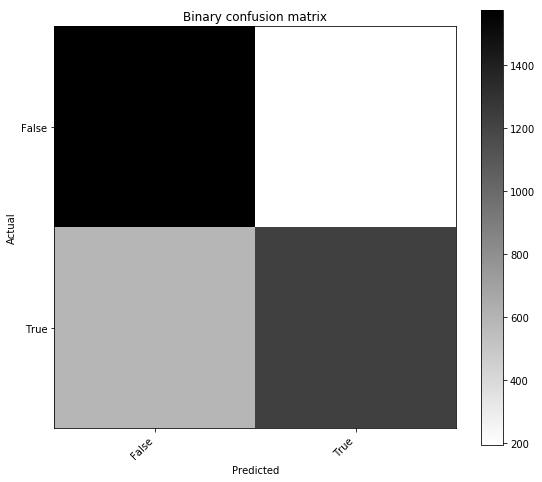

In [168]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [169]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.8833301582970535


In [170]:
# Results at 60 epochs, 1 iteration:
# Just Govecs i think was like .84 AUC
# DisPhen and GoVecs: .88 AUC
# Chebi, disphen, govecs: .895 AUC then .873 on second round... once off results are pointless at this level diff

In [171]:
# Error out to stop notebook
for a in i
def 


SyntaxError: invalid syntax (<ipython-input-171-440e5fd394b4>, line 2)

In [ ]:
# Save entire model to a HDF5 file
model.save('nn20022019auc889GOpro.h5')

In [ ]:
# 

In [ ]:
# testers.shape[0]

In [ ]:
# testers.head()

In [ ]:
# # Version for GoFuncs, DIS-Phens, CHEBI, DO, HINO, PRO
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(testers.DVec.values.tolist(), index= testers.index)
# Cvecs = pd.DataFrame(testers.CVec.values.tolist(), index= testers.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(testers.disPhenVecHP.values.tolist(), index= testers.index)
# DHPvecs = pd.DataFrame(testers.disPhenVecMP.values.tolist(), index= testers.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# all_X = disPvecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# CHEBvecs = pd.DataFrame(testers.CHEBIvec.values.tolist(), index = testers.index)
# all_X = CHEBvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# DOvecs = pd.DataFrame(testers.DOvec.values.tolist(), index = testers.index)
# all_X = DOvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# dHINOvecs = pd.DataFrame(testers.dis_HINOvec.values.tolist(), index=testers.index)
# cHINOvecs = pd.DataFrame(testers.chem_HINOvec.values.tolist(), index=testers.index)
# hinovecs = cHINOvecs.merge(dHINOvecs, how='outer', left_index=True, right_index=True)
# all_X = all_X.merge(hinovecs, how='outer', left_index=True, right_index=True)

# dPROvecs = pd.DataFrame(testers.dis_PROvec.values.tolist(), index=testers.index)
# cPROvecs = pd.DataFrame(testers.chem_PROvec.values.tolist(), index=testers.index)
# PROvecs = cPROvecs.merge(dPROvecs, how='outer', left_index=True, right_index=True)
# all_X = PROvecs.merge(all_X, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [ ]:
# # Now create np array of the y output
# all_y = np.array(testers.Correlation)

In [ ]:
# # Accuracy
# test_loss, test_acc = model.evaluate(all_X, all_y)
# print('Test accuracy:', test_acc)

# # Get actual predictions for test set
# predictions = model.predict(all_X)
# rounded_predictions = [int(float(round(x[0]))) for x in predictions]
# print('ROC AUC: ', roc_auc_score(all_y, predictions))


### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [ ]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [ ]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [ ]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [ ]:
df_cd.head()

In [ ]:
test_set.head()

In [ ]:
# test_set.DiseaseID.nunique()

In [ ]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

In [ ]:
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    print(col,  df_cd.columns)
    if str(col) in df_cd.columns: print('sd') # df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')

In [ ]:
mem_usage(df_cd)

In [ ]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
# lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
# del lst
# test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
# for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
#     if col in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
#     if col in test_set.columns: test_set[col] = test_set[col].astype('category')

test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [ ]:
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
type(df_cd.ChemicalID[1])

In [ ]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions']].to_csv('predictions.csv', index=False)

In [ ]:
test_set.head()

In [ ]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

In [ ]:
test_set.head()

In [ ]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similarity

In [ ]:
# df1.head()

In [ ]:
# # Calculate out the cosine similarity and see if there's a difference between groups
# def cosine_sim (row):
#     return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

# df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# # Compare cosine sim of correlated and uncorrelated groups
# print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
# print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [ ]:
# Save entire model to a HDF5 file
model.save('nn15022019auc92GoPhenCHEdoHIpro.h5')